In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

def style_plot(fig, ax, aspect="equal", no_ticks=False, no_xticks=False, no_yticks=False):

    # Remove white space
    fig.tight_layout()

    # Makes axes aspect equal
    if aspect:
        ax.set_aspect(aspect)

    # Make tick labels bold font
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(20)

    # Make border thicker
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

    # xy_ticks
    major_tick_length = 7
    minor_tick_length = 4
    if no_ticks:
        major_xtick_length = 0
        major_ytick_length = 0
        minor_xtick_length = 0
        minor_ytick_length = 0
    elif no_xticks:
        major_xtick_length = 0
        major_ytick_length = major_tick_length
        minor_xtick_length = 0
        minor_ytick_length = minor_tick_length
    elif no_yticks:
        major_xtick_length = major_tick_length
        major_ytick_length = 0
        minor_xtick_length = minor_tick_length
        minor_ytick_length = 0
    else:
        major_xtick_length = major_tick_length
        major_ytick_length = major_tick_length
        minor_xtick_length = minor_tick_length
        minor_ytick_length = minor_tick_length
    ax.tick_params(axis='x', which='major', length=major_xtick_length, width=2, direction='out')
    ax.tick_params(axis='y', which='major', length=major_ytick_length, width=2, direction='out')
    ax.tick_params(axis='x', which='minor', length=minor_xtick_length, width=1, direction='out')
    ax.tick_params(axis='y', which='minor', length=minor_ytick_length, width=1, direction='out')

In [2]:
def calculate_pde_eigenvalues(m, n):
    return np.sqrt((1 / 3 * (2 * np.pi * m)**2 + 2 / 3 * (2 * np.pi * n)**2))

In [3]:
file = open("tiling/rectangular_periodic/eigenvalue_data.pkl", "rb")
eigenvalue_data = pickle.load(file)
file.close()

In [5]:
eigenvalue_data[8712]

array([1.37735081e-15, 3.62714210e+00, 5.12987627e+00, 6.28318531e+00,
       7.25154428e+00, 8.88408747e+00, 1.02578100e+01, 1.08704660e+01,
       1.08814235e+01, 1.20225689e+01, 1.25663706e+01, 1.44811654e+01,
       1.49541994e+01])

In [10]:
m, n = 1, 0
print(np.sqrt((1 / 3 * (np.pi * m)**2 + 2 / 3 * (2 * np.pi * n)**2)))
print(calculate_pde_eigenvalues(m, n))

1.8137993642342176
3.6275987284684352


### Functions specific to rectangular lattice

In [3]:
def calculate_pde_eigenvalues(m, n):
    return np.sqrt((1 / 3 * (2 * np.pi * m)**2 + 2 / 3 * (2 * np.pi * n)**2))

In [4]:
powers_of_10_lims = (2, 4)
num_Vs_per_tile = 4
num_graphs_per_power_of_10 = 5
total_dpowers = num_graphs_per_power_of_10 * (powers_of_10_lims[1] - powers_of_10_lims[0]) + 1
power_linspace = np.linspace(powers_of_10_lims[0], powers_of_10_lims[1], total_dpowers)

tiles_per_dim = np.int32(np.sqrt(10**power_linspace / num_Vs_per_tile) * 2 / 3)

# Start calculations

In [32]:
run_eigenvalue_calculations = False

if run_eigenvalue_calculations:
    guesses = np.concatenate([np.array([1e-15]), np.linspace(3, 15, 250)])

    eigenvalue_data = {}

    for tile_num in tiles_per_dim[:4]:
        g = construct_graph.tiling.Tiling(tile_type='rectangular_tile',
                                          num_horizontal_displacements=tile_num * 2,
                                          num_vertical_displacements=tile_num,
                                          autoplot=False)
        print(f"num_Vs = {g.num_Vs}")
        print("\n\n\n")
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        ks = eigs(guesses, printerval=1000, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
        _, index = np.unique(np.round(ks, 6), return_index=True)
        eigenvalues = ks[index]
        eigenvalue_data[g.num_Vs] = eigenvalues.copy()

num_Vs = 72





Calculating eig number 0

----------------------
Converged at step 0:

k = -9.679757852927214e-16
----------------------

Calculating eig number 1

----------------------
Converged at step 4:

k = 3.5722909430364154
----------------------

Calculating eig number 2

----------------------
Converged at step 4:

k = 3.5722909430364114
----------------------

Calculating eig number 3

----------------------
Converged at step 4:

k = 3.5722909430364105
----------------------

Calculating eig number 4

----------------------
Converged at step 4:

k = 3.5722909430364123
----------------------

Calculating eig number 5

----------------------
Converged at step 4:

k = 3.5722909430364154
----------------------

Calculating eig number 6

----------------------
Converged at step 4:

k = 3.5722909430364136
----------------------

Calculating eig number 7

----------------------
Converged at step 4:

k = 3.572290943036415
----------------------

Calculating eig number 8

----------

In [5]:
mn = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]

In [66]:
class Projector:

    def __init__(self, g, eigenvalues):

        self.data = {}
        self.modes = Graph_Modes(g, eigenvalues)
        self.V_coords = g.V_coords
        self.g_coords = g.g_coords

    def generate_basis_functions(self, m, n):

        if (m > 2) or (n > 2) or (m < 0) or (n < 0):
            raise ValueError("Projector is only set up for m, n \in [0, 1, 2]")

        if m == 0 and n == 0:
            return lambda x, y: np.ones(x.shape), 

        cc = lambda m, n: lambda x, y: np.cos(2 * np.pi * m * x) * np.cos(2 * np.pi * n * y)
        cs = lambda m, n: lambda x, y: np.cos(2 * np.pi * m * x) * np.sin(2 * np.pi * n * y)
        sc = lambda m, n: lambda x, y: np.sin(2 * np.pi * m * x) * np.cos(2 * np.pi * n * y)
        ss = lambda m, n: lambda x, y: np.sin(2 * np.pi * m * x) * np.sin(2 * np.pi * n * y)

        if m == 0:
            return cc(m, n), cs(m, n)
        elif n == 0:
            return cc(m, n), sc(m, n)
        elif (m == 1) and (n == 2):
            return cc(m, n), cs(m, n), sc(m, n), ss(m, n), cc(3, 0), sc(3, 0)
        else:
            return cc(m, n), cs(m, n), sc(m, n), ss(m, n)

    def construct_pde_functions(self, m, n, function_domain="vertices"):

        basis_functions = self.generate_basis_functions(m, n)

        if function_domain == "vertices":
            x, y = self.V_coords[:, 0], self.V_coords[:, 1]

            pde_eigenvectors = [function(x, y) for function in basis_functions]
            pde_eigenvectors = [function / np.linalg.norm(function) for function in pde_eigenvectors]
            pde_eigenvectors = np.vstack((pde_eigenvectors)).T

            return pde_eigenvectors
        
        elif function_domain == "graph":
            pde_eigenfunctions = [[] for _ in range(len(basis_functions))]

            for edge in self.g_coords:
                x, y = edge
                
                for i in range(len(basis_functions)):
                    pde_eigenfunctions[i].append(basis_functions[i](x, y))

            pde_eigenfunctions = [Graph_Function(pde_eigenfunction, self.g_coords).normalize() 
                                  for pde_eigenfunction in pde_eigenfunctions]
            
            return pde_eigenfunctions

        elif function_domain == "continuum":
            edge = np.linspace(0, 1, 256, endpoint=True)   
            x, y = np.meshgrid(edge, edge)
            pde_eigenfunctions = [function(x, y) for function in basis_functions]

            return x, y, pde_eigenfunctions

    def find_graph_eigenspace(self, m, n):

        pde_eigenvectors = self.construct_pde_functions(m, n, function_domain="vertices")
        num_basis_functions = pde_eigenvectors.shape[1]
        prod = pde_eigenvectors.T @ pde_eigenvectors
        invert_prod = np.linalg.inv(prod)
        proj = (pde_eigenvectors @ invert_prod @ pde_eigenvectors.T)

        keep_args = proj @ self.modes.graph_eigenvectors
        keep_args = np.argsort(np.linalg.norm(keep_args, axis=0))[-num_basis_functions:]

        # Handle when the graph eigenspace is larger than the PDE eigenspace
        uniques, counts = np.unique(np.round(self.modes.graph_eigenvalues[keep_args], 10), return_counts=True)
        new_keep_args = []
        for unique, count in zip(uniques, counts):
            where_equal = np.where(np.abs(self.modes.graph_eigenvalues - unique) < 1e-9)[0]
            if np.shape(where_equal)[0] != count:
                message = (f"For m={m},n={n}, the graph eigenspace is larger than the PDE eigenspace. " + 
                            "This might be (a) a problem, (b) saying something interesting, or (c) nothing special.")
                warnings.warn(message)
            new_keep_args.append(where_equal)
        keep_args = np.concatenate((new_keep_args))

        return keep_args

    def __call__(self, m, n):

        self.data[m, n] = {"graph": {}, "PDE": {}}

        # Get PDE eigenvalues
        self.data[m, n]["PDE"]["eigenvalue"] = calculate_pde_eigenvalues(m, n)

        # Get PDE eigenfunctions
        pde_eigenfunctions = self.construct_pde_functions(m, n, function_domain="graph")
        self.data[m, n]["PDE"]["eigenfunction"] = pde_eigenfunctions
        
        # Get graph eigenvalues
        keep_args = self.find_graph_eigenspace(m, n)
        self.data[m, n]["graph"]["eigenvalue"] = self.modes.graph_eigenvalues[keep_args]

        # Get graph eigenfunctions
        project_functions = []
        for pde_eigenfunction in pde_eigenfunctions:
            projection = []
            for arg in keep_args:
                ip = pde_eigenfunction.dot(self.modes.graph_eigenfunctions[arg])
                projection.append(ip * self.modes.graph_eigenfunctions[arg])
            project_functions.append(np.sum(projection))
        self.data[m, n]["graph"]["eigenfunction"] = project_functions 

In [75]:
full_data = {}

for tile_num in tiles_per_dim:

    g = construct_graph.tiling.Tiling(tile_type='rectangular_tile',
                                      num_horizontal_displacements=tile_num * 2,
                                      num_vertical_displacements=tile_num,
                                      autoplot=False)
    p = Projector(g, eigenvalue_data[g.num_Vs])
    for m, n in mn:
        p(m, n)
    full_data[g.num_Vs] = p.data

/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_40483/2164500301.py:85: UserWarning: For m=2,n=2, the graph eigenspace is larger than the PDE eigenspace. This might be (a) a problem, (b) saying something interesting, or (c) nothing special.
  warnings.warn(message)


In [90]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
order_line_color = colors[6]
colors = colors[:6] + colors[7:]
def plot_loglog_rel_err(Num_Vs, rel_errs):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6), gridspec_kw={'height_ratios': [6, 1]})
    fig.subplots_adjust(hspace=0.2, )  # adjust space between axes

    # Separate data by size
    for en, rel_err in enumerate(rel_errs.T):
        if np.all(rel_err > 1e-10):
            ax1.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])
        else:
            ax2.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])
            if np.any(rel_err > 1e-10):
                relevant_data = rel_err[rel_err <= 1e-10]
                ax2.set_ylim(0.1 * np.min(relevant_data), 10 * np.max(relevant_data))

    # Setup convergence line
    ax1_data_lims = (np.min(rel_errs[rel_errs > 1e-10]), np.max(rel_errs[rel_errs > 1e-10]))
    ax1_log_dif = np.log10(ax1_data_lims[1]) - np.log10(ax1_data_lims[0])
    max_order_height = np.max(rel_errs) / np.max(Num_Vs**(-1.))
    order_line_data = max_order_height * Num_Vs**(-1.) * 10**(0.15 * ax1_log_dif)
    # order_line_data = max_order_height * Num_Vs**(-1.) * 1
    ax1.loglog(Num_Vs, order_line_data, 
               linewidth=4, c=order_line_color)

    # hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # Slanted lines
    d = 0.5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=3, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    style_plot(fig, ax1, aspect=None, no_xticks=True)
    style_plot(fig, ax2, aspect=None)

    return fig, fig.axes

In [88]:
edata = Eigendata(full_data)

(<Figure size 700x600 with 2 Axes>, [<Axes: >, <Axes: >])

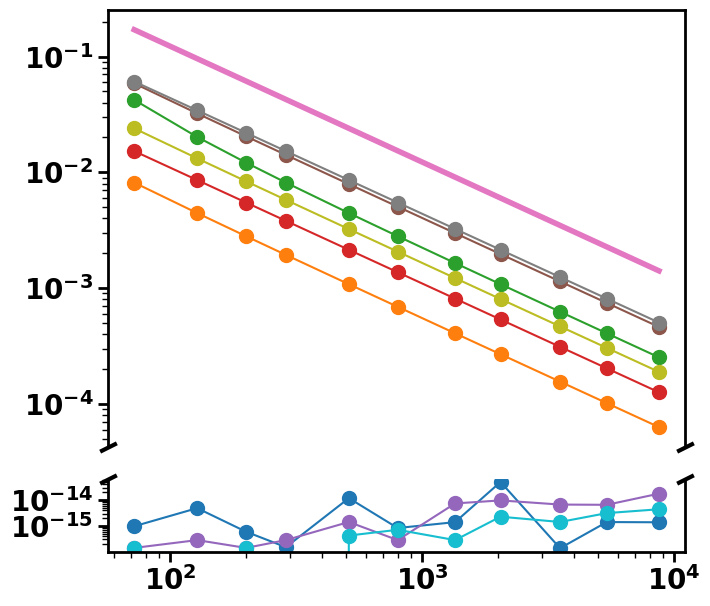

In [91]:
x = edata.V_nums
y = np.array(list(edata.relative_eigenvalue_differences.values())).T
plot_loglog_rel_err(x, y)
# plt.savefig("tiling/rectangular_periodic/rectangular_periodic_tiling_eigenfunction_relerr.png", dpi=200, bbox_inches='tight')

### Load and plot modes

In [ ]:
file = open("tiling/rectangular_periodic/eigendata.pkl", "rb")
full_data = pickle.load(file)
file.close()

In [8]:
tile_num = tiles_per_dim[4]

g = construct_graph.tiling.Tiling(tile_type='rectangular_tile',
                                    num_horizontal_displacements=tile_num * 2,
                                    num_vertical_displacements=tile_num,
                                    autoplot=False)
print(g.num_Vs)

512


In [12]:
emode = full_data[g.num_Vs][0, 1]['graph']['eigenfunction']

In [25]:
for m, n in mn:
    emodes = full_data[g.num_Vs][m, n]['graph']['eigenfunction']
    for en, emode in enumerate(emodes):
        fig, ax = g.plot_graph(eigenmode=emode.data, return_figax=True, background_color="black", linewidth=generate_graph_linewidth(g.num_Vs))
        plt.savefig(f"tiling/rectangular_periodic/mode_plots/eigenmode_{g.num_Vs}Vs_m{m}_n{n}_number{en}.png", dpi=200, bbox_inches='tight')
        plt.close()

In [67]:
p = Projector(g, eigenvalue_data[g.num_Vs])

In [85]:
for m, n in [[0, 0], [0, 1], [1, 0], [1, 1]]:
    x, y, A = p.construct_pde_functions(m, n, function_domain="continuum")
    for en, a in enumerate(A):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        ax.pcolormesh(x, y, a, cmap="plasma", shading='auto')
        style_plot(fig, ax, aspect="equal", no_ticks=True)
        ax.axis('off')
        fig.set_facecolor("black")
        plt.savefig(f"tiling/rectangular_periodic/PDE_mode_plots/continuum_eigenmode_m{m}_n{n}_number{en}.png", dpi=200, bbox_inches='tight')
        plt.close()